In [5]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
import torch.functional as F
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from model import Encoder, Decoder, SelfAttentionEncoder, AutoEncoder, get_trainable_params, train
from torch.autograd.functional import jacobian
print(torch.__version__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.0.0


In [10]:
#Test
input_dim = 500
factor_dim = 20
enc = Encoder(hidden_dim = [input_dim, 200, 100, factor_dim], lastLayerLinear=True)
print(enc)
X = torch.randn(64, input_dim)
res = enc.forward(X)
print(res.shape)
#print(enc)

#Test
input_dim = 500
factor_dim = 20
dec = Decoder(hidden_dim = [factor_dim, 100, input_dim])
print(dec)
X = torch.randn(64, factor_dim)
res = dec.forward(X)
print(res.shape)
#print(dec)

mod = AutoEncoder(enc, dec)
X = torch.randn(64, input_dim)
res = mod.forward(X)
print(res.shape)

#print(mod)

Encoder(
  (sequential): Sequential(
    (linear_0): Linear(in_features=500, out_features=200, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=200, out_features=100, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=100, out_features=20, bias=True)
    (activation_2): Identity()
  )
)
torch.Size([64, 20])
<class 'torch.nn.modules.activation.Tanh'>
Decoder(
  (sequential): Sequential(
    (linear_0): Linear(in_features=20, out_features=100, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=100, out_features=500, bias=True)
    (activation_1): Tanh()
  )
)
torch.Size([64, 500])
torch.Size([64, 500])


In [5]:
def simulateVar(x0, delta, lamda, T, mu, omega):
    assert delta.shape[0] == x0.shape[0] == lamda.shape[0] == x0.shape[0] == omega.shape[0] == mu.shape[0], 'Incorrect shapes'
    eigval, _ = np.linalg.eig(lamda)
    if not (np.abs(eigval)<=1.).all(): print(f"Warning: this system is unstable. Eigenvalues: {eigval}")
    res = [x0]
    for t in range(T):
        residuals = np.random.multivariate_normal(mu,omega)
        xt = delta + lamda @ res[-1] + residuals
        res.append(xt)
    y = np.array(res)
    y= (y-y.min(axis=0))/(y.max(axis=0)-y.min(axis=0))
    return y

def simulateRandomVar(k, T=100, warmup=0.1):
    D = np.diag(np.random.uniform(0,1, size=(k))) #eigenvalues
    V = np.random.normal(size=(k,k))
    lamda = np.linalg.inv(V) @ D @ V #similarity transform
    #print(np.linalg.eig(lamda))
    x0 = np.random.normal(size=(k))
    delta = np.random.normal(size=(k))
    mu = np.zeros(k)
    omega = np.identity((k))
    res = simulateVar(x0,delta,lamda,T,mu,omega)
    return res[int(0.1*T):]


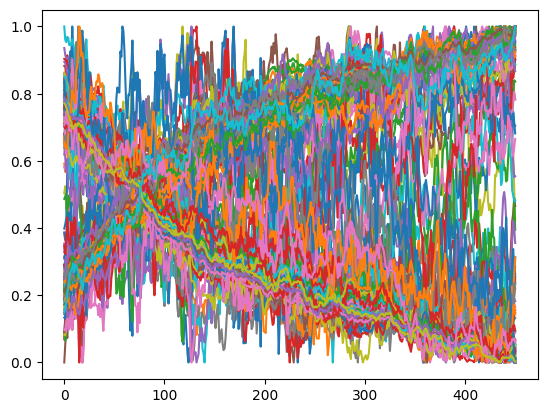

In [6]:
d = 200
sim = simulateRandomVar(d,T=500)
plt.plot(sim);

232310
AutoEncoder(
  (enc): Encoder(
    (activation): Tanh()
    (sequential): Sequential(
      (0): Linear(in_features=200, out_features=100, bias=True)
      (1): Tanh()
      (2): Linear(in_features=100, out_features=10, bias=True)
      (3): Tanh()
    )
  )
  (dec): Decoder(
    (activation): Tanh()
    (sequential): Sequential(
      (0): Linear(in_features=10, out_features=1000, bias=True)
      (1): Tanh()
      (2): Linear(in_features=1000, out_features=200, bias=True)
    )
  )
)
split 315
torch.Size([451, 200]) torch.Size([135, 200])
451 1


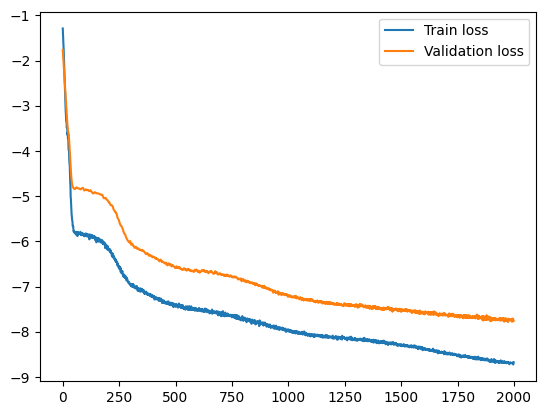

In [7]:
X = torch.from_numpy(sim).float()
input_dim = d
factor_dim = 10
enc = Encoder(hidden_dim = [input_dim, 100, factor_dim], activation=nn.Tanh(), lastLayerLinear=False) 
dec = Decoder(hidden_dim = [factor_dim, 1000, input_dim], activation=nn.Tanh())
model = AutoEncoder(enc, dec)
print(get_trainable_params(model))
print(model)
#criterion = OrthoLoss(enc=enc,alpha=10)
criterion = nn.MSELoss()
train_hist = train(X=X, model=model, n_epoch=2000, optimizer=optim.Adam, criterion=criterion, lr=0.0001, use_val=True, val_split = 0.3, batch_size=256)
#plt.plot(np.log(train_hist['loss']))
plt.plot(np.log(train_hist['loss']), label = 'Train loss')
plt.plot(np.log(train_hist['val_loss']), label='Validation loss')
plt.legend()

Text(0.5, 1.0, 'First principal component')

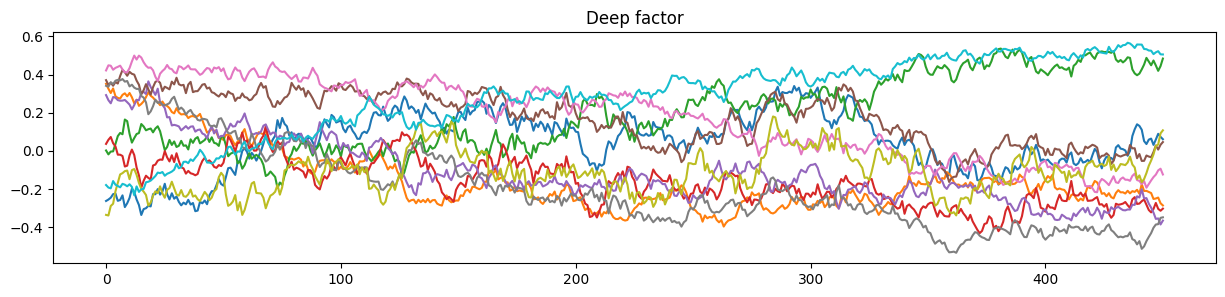

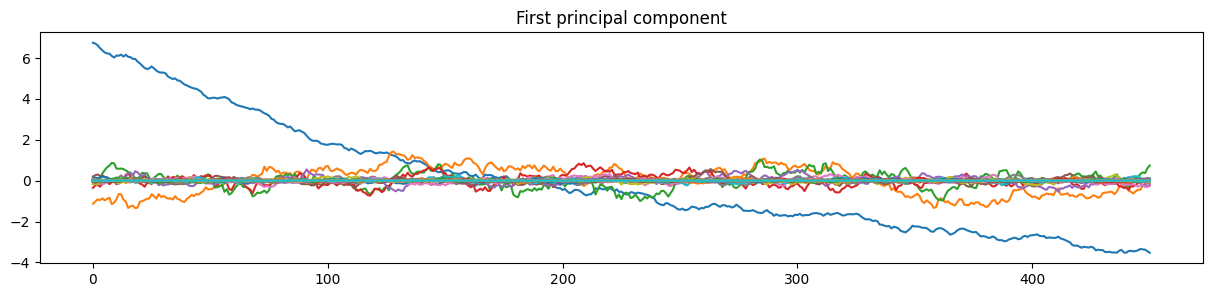

In [8]:
#plot factors
plt.figure(figsize=(15,3))
plt.plot(model.enc(X).detach().numpy());
plt.title('Deep factor')

#compare to PCA
pca = PCA(n_components=d)
pc = pca.fit_transform(X)
plt.figure(figsize=(15,3))
plt.plot(pc);
plt.title('First principal component')


Text(0.5, 1.0, '$\\hat y$')

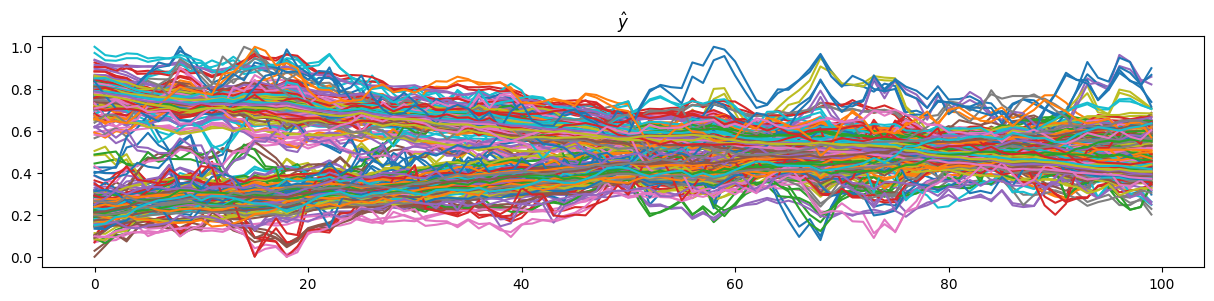

In [9]:
#plot reconstructed y_hat
plt.figure(figsize=(15,3))
y_hat = model(X).detach().numpy()
plt.plot(y_hat[0:100]);
plt.plot(X[0:100])
plt.title('$\hat y$')

In [41]:
#hyperparameter opt
from hyperopt import hyper_optimizer

res = hyper_optimizer(X)

(<lambda> pid=77589) split 315
(<lambda> pid=77589) 451 3 [repeated 2x across cluster]
(<lambda> pid=77593) 451 3
(<lambda> pid=77593) 451 3 [repeated 2x across cluster]
(<lambda> pid=77595) split 315


Trial name,date,done,hostname,iterations_since_restore,node_ip,pid,score,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
lambda_d5364_00000,2023-04-29_16-26-37,False,Julians-MBP,1,127.0.0.1,77589,0.838227,0.0580397,0.0580397,0.0580397,1682778397,1,d5364_00000
lambda_d5364_00001,2023-04-29_16-26-49,False,Julians-MBP,20,127.0.0.1,77593,0.715556,5.06592,0.0210121,5.06592,1682778409,20,d5364_00001
lambda_d5364_00002,2023-04-29_16-26-49,False,Julians-MBP,1,127.0.0.1,77595,0.878336,0.0634513,0.0634513,0.0634513,1682778409,1,d5364_00002


2023-04-29 16:32:43,944	INFO tune.py:945 -- Total run time: 373.97 seconds (373.90 seconds for the tuning loop).


In [42]:
print(res)

ResultGrid<[
  Result(
    metrics={'score': 0.03755951672792435, 'done': True, 'trial_id': 'd5364_00000', 'experiment_tag': '0_dec_activation=Identity,dec_hidden=0,enc_activation=Identity,enc_hidden=0'},
    path='/Users/julianvanmeggelen/ray_results/lambda_2023-04-29_16-26-29/lambda_d5364_00000_0_dec_activation=Identity,dec_hidden=0,enc_activation=Identity,enc_hidden=0_2023-04-29_16-26-30',
    checkpoint=None
  ),
  Result(
    metrics={'score': 0.056219056248664856, 'done': True, 'trial_id': 'd5364_00001', 'experiment_tag': '1_dec_activation=Tanh,dec_hidden=0,enc_activation=Identity,enc_hidden=0'},
    path='/Users/julianvanmeggelen/ray_results/lambda_2023-04-29_16-26-29/lambda_d5364_00001_1_dec_activation=Tanh,dec_hidden=0,enc_activation=Identity,enc_hidden=0_2023-04-29_16-26-37',
    checkpoint=None
  ),
  Result(
    metrics={'score': 0.04192895442247391, 'done': True, 'trial_id': 'd5364_00002', 'experiment_tag': '2_dec_activation=Sigmoid,dec_hidden=0,enc_activation=Identity,enc

In [45]:
dir(res)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_annotated',
 '_experiment_analysis',
 '_local_path',
 '_populate_exception',
 '_remote_path',
 '_results',
 '_trial_to_result',
 'errors',
 'experiment_path',
 'get_best_result',
 'get_dataframe',
 'num_errors',
 'num_terminated']

In [43]:
res.get_best_result('score', 'min')

Result(
  metrics={'score': 0.025605101138353348, 'done': True, 'trial_id': 'd5364_00055', 'experiment_tag': '55_dec_activation=Tanh,dec_hidden=0,enc_activation=Identity,enc_hidden=40'},
  path='/Users/julianvanmeggelen/ray_results/lambda_2023-04-29_16-26-29/lambda_d5364_00055_55_dec_activation=Tanh,dec_hidden=0,enc_activation=Identity,enc_hidden=40_2023-04-29_16-30-54',
  checkpoint=None
)

In [ ]:
res.get_dataframe()

,score,time_this_iter_s,done,training_iteration,trial_id,date,timestamp,time_total_s,pid,hostname,...,config/dec_activation,config/dec_hidden,config/enc_activation,config/enc_hidden,config/factor_dim,config/lr,config/n_epoch,config/optimizer,config/val_split,logdir
0,0.037560,0.024259,False,500,d5364_00000,2023-04-29_16-27-08,1682778428,31.087795,77589,Julians-MBP,...,Identity,0,Identity,0,10,0.0001,500,<class 'torch.optim.adam.Adam'>,0.3,/Users/julianvanmeggelen/ray_results/lambda_20...
1,0.056219,0.033843,False,500,d5364_00001,2023-04-29_16-27-09,1682778429,24.563668,77593,Julians-MBP,...,Tanh,0,Identity,0,10,0.0001,500,<class 'torch.optim.adam.Adam'>,0.3,/Users/julianvanmeggelen/ray_results/lambda_20...
2,0.041929,0.031364,False,500,d5364_00002,2023-04-29_16-27-09,1682778429,19.990534,77595,Julians-MBP,...,Sigmoid,0,Identity,0,10,0.0001,500,<class 'torch.optim.adam.Adam'>,0.3,/Users/julianvanmeggelen/ray_results/lambda_20...
3,0.050329,0.024743,False,500,d5364_00003,2023-04-29_16-27-09,1682778429,13.407077,77597,Julians-MBP,...,Identity,20,Identity,0,10,0.0001,500,<class 'torch.optim.adam.Adam'>,0.3,/Users/julianvanmeggelen/ray_results/lambda_20...
4,0.041373,0.051973,False,500,d5364_00004,2023-04-29_16-27-22,1682778442,13.396162,77589,Julians-MBP,...,Tanh,20,Identity,0,10,0.0001,500,<class 'torch.optim.adam.Adam'>,0.3,/Users/julianvanmeggelen/ray_results/lambda_20...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.046527,0.028644,False,500,d5364_00076,2023-04-29_16-32-35,1682778755,15.162405,77589,Julians-MBP,...,Tanh,20,Sigmoid,40,10,0.0001,500,<class 'torch.optim.adam.Adam'>,0.3,/Users/julianvanmeggelen/ray_results/lambda_20...
77,0.073408,0.022440,False,500,d5364_00077,2023-04-29_16-32-37,1682778757,14.870922,77595,Julians-MBP,...,Sigmoid,20,Sigmoid,40,10,0.0001,500,<class 'torch.optim.adam.Adam'>,0.3,/Users/julianvanmeggelen/ray_results/lambda_20...
78,0.039287,0.022405,False,500,d5364_00078,2023-04-29_16-32-38,1682778758,14.444220,77593,Julians-MBP,...,Identity,40,Sigmoid,40,10,0.0001,500,<class 'torch.optim.adam.Adam'>,0.3,/Users/julianvanmeggelen/ray_results/lambda_20...
79,0.036756,0.013478,False,500,d5364_00079,2023-04-29_16-32-41,1682778761,12.677023,77597,Julians-MBP,...,Tanh,40,Sigmoid,40,10,0.0001,500,<class 'torch.optim.adam.Adam'>,0.3,/Users/julianvanmeggelen/ray_results/lambda_20...


(raylet) [2023-04-29 21:55:58,512 E 71423 3137605] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-04-28_22-20-11_030245_71328 is over 95% full, available space: 12464046080; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2023-04-29 21:56:08,595 E 71423 3137605] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-04-28_22-20-11_030245_71328 is over 95% full, available space: 11115487232; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2023-04-29 21:56:18,644 E 71423 3137605] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-04-28_22-20-11_030245_71328 is over 95% full, available space: 11371757568; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2023-04-29 21:56:28,695 E 71423 3137605] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-04-28_22-20-11_030245_71328 is over 95% full, available space: 12133945344; capacity: 250685575168. Object 

In [20]:
f = torch.rand((10))

jacobian(model.dec,f).shape

torch.Size([500, 10])

In [1]:
f.detach().numpy()

NameError: name 'f' is not defined

In [12]:
from filterpy.kalman import ExtendedKalmanFilter as ExtendedKalmanFilter
dim_x = factor_dim
dim_z = d
ekf = ExtendedKalmanFilter(dim_x, dim_z)
#ekf.R = np.ones((dim_z))
#ekf.Q = np.diag(np.ones(dim_z))
ekf.F = np.diag(np.ones(dim_x))
#ekf.P = np.diag(np.ones(dim_x))
ekf.x = f.detach().numpy()
decoder = model.dec
Hx = lambda state: decoder(torch.Tensor(state).float()).detach().numpy()
HJacobian = lambda state: jacobian(decoder,torch.Tensor(state).float()).detach().numpy()
xs = []
zs = []
for i in range(200):
    z = y_[i,:]
    ekf.update(z, HJacobian, Hx)
    xs.append(ekf.x)
    ekf.predict()
    zs.append(ekf.z)
plt.plot(np.stack(xs));
plt.figure()
plt.plot(np.stack(zs));


NameError: name 'd' is not defined